<a id=top></a>
# Custom CCD Darks <a class="tocSkip">

<h1>Learning Goals<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#Import-Necessary-Packages" data-toc-modified-id="Import-Necessary-Packages-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import Necessary Packages</a></span></li><li><span><a href="#Collect-Data-Set-From-the-MAST-Archive-Using-Astroquery" data-toc-modified-id="Collect-Data-Set-From-the-MAST-Archive-Using-Astroquery-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Collect Data Set From the MAST Archive Using Astroquery</a></span></li></ul></li><li><span><a href="#Default-Dark-File" data-toc-modified-id="Default-Dark-File-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Default Dark File</a></span></li><li><span><a href="#Make-Basedark" data-toc-modified-id="Make-Basedark-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Make Basedark</a></span></li><li><span><a href="#Make-Weekdark" data-toc-modified-id="Make-Weekdark-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Make Weekdark</a></span></li><li><span><a href="#Calibrate-with-New-Weekdark" data-toc-modified-id="Calibrate-with-New-Weekdark-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Calibrate with New Weekdark</a></span><ul class="toc-item"><li><span><a href="#Calibration" data-toc-modified-id="Calibration-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Calibration</a></span></li><li><span><a href="#Comparison-With-the-Default-Dark-File" data-toc-modified-id="Comparison-With-the-Default-Dark-File-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Comparison With the Default Dark File</a></span></li></ul></li></ul></div>

## Introduction
In the Calstis pipline for calibrating STIS CCD data, one of the steps is dark signal substraction, which removes the dark signal (count rate created in the detector in the absence of photons from the sky) from the uncalibrated science image based on reference file. Usually, the Calstis pipline uses the default dark reference file specified in the 0-extension header of the uncalibrated science image fits file. But for some faint sources, it is necessary to customize the dark reference for the observations to remove the hot pixels in the science image. In this notebook, we will go through how to create dark reference files using the Python refstis library.

**Notice: this notebook demonstrates a squence of steps to customize dark reference file. If any of the intermediate steps fail or need to rerun, please restart the ipython kernel and start from the first step.**

### Import Necessary Packages
- `astropy.io fits` `astropy.table` for accessing FITS files
- `astroquery.mast Observations` for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive
- `os`,`shutil`,`pathlib` for managing system paths
- `numpy` to handle array functions
- `stistools` for calibrating STIS data
- `refstis` for creating STIS reference files
- `matplotlib` for plotting data

For more information on installing refstis, see: [`Refstis: Superdarks and Superbiases for STIS`](https://refstis.readthedocs.io/en/latest/)

In [1]:
# Import for: Reading in fits file
from astropy.io import fits
from astropy.table import Table

# Import for: Downloading necessary files. (Not necessary if you choose to collect data from MAST)
from astroquery.mast import Observations

# Import for: Managing system variables and paths
import os
import shutil
from pathlib import Path

# Import for: Quick Calculation and Data Analysis
import numpy as np

# Import for: Operations on STIS Data
import stistools
from refstis.basedark import make_basedark
from refstis.weekdark import make_weekdark

# Import for: Plotting and specifying plotting parameters
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.cmap'] = 'plasma'
matplotlib.rcParams['image.interpolation'] = 'none'
matplotlib.rcParams['figure.figsize'] = (20, 10)

/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/stsci/tools/nmpfit.py:8: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/stsci/tools/gfit.py:18: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


### Collect Data Set From the MAST Archive Using Astroquery
There are other ways to download data from MAST such as using CyberDuck. The steps of collecting data is beyond the scope of this notebook, and we are only showing how to use astroquery and CRDS.

In [2]:
%%capture --no-display
# cleanup download directory
if os.path.exists('./mastDownload'):
    shutil.rmtree('./mastDownload')

# change this field in you have a specific dataset to be explored
obs_id = "oeik1s030"
# Search target by obs_id
target = Observations.query_criteria(obs_id=obs_id)
# get a list of files assiciated with that target
FUV_list = Observations.get_product_list(target)
# Download fits files
result = Observations.download_products(FUV_list, extension='fits')
crj = os.path.join("./mastDownload/HST", "{}".format(obs_id), "{}_crj.fits".format(obs_id))

Next, use the [Calibration Reference Data System](https://hst-crds.stsci.edu) (CRDS) [command line tools](https://hst-crds.stsci.edu/static/users_guide/command_line_tools.html) to update and download the reference files for creating the basedark. 

In [3]:
crds_path = os.path.expanduser("~") + "/crds_cache"
os.environ["CRDS_PATH"] = crds_path
os.environ["CRDS_SERVER_URL"] = "https://hst-crds.stsci.edu"
os.environ["oref"] = os.path.join(crds_path, "references/hst/oref/")

In [4]:
!crds bestrefs --update-bestrefs --sync-references=1 --files ./mastDownload/HST/oeik1s030/oeik1s030_raw.fits

CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfpc2_wf4tfile_0250.rmap      678 bytes  (1 / 142 files) (0 / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfpc2_shadfile_0250.rmap      977 bytes  (2 / 142 files) (678 / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfpc2_offtab_0250.rmap      642 bytes  (3 / 142 files) (1.7 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfpc2_maskfile_0250.rmap      685 bytes  (4 / 142 files) (2.3 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfpc2_idctab_0250.rmap      696 bytes  (5 / 142 files) (3.0 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfpc2_flatfile_0250.rmap   30.0 K bytes  (6 / 142 files) (3.7 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfpc2_dgeofile_0250.rmap      801 bytes  (7 / 142 files) (33.7 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfpc2_darkfile_0250.rmap  178.4 K bytes  (8 / 142 files) (34.5 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfpc2_biasfile_0250.rmap    3.3 K bytes  (9 / 142 files) (212.8 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfpc2_atodfile_0250.rmap      874 bytes  (10 / 142 files) (216.1 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfpc2_0250.imap      782 bytes  (11 / 142 files) (217.0 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_snkcfile_0003.rmap      681 bytes  (12 / 142 files) (217.8 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_satufile_0002.rmap    1.0 K bytes  (13 / 142 files) (218.5 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_pfltfile_0253.rmap   34.2 K bytes  (14 / 142 files) (219.5 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_pctetab_0004.rmap      698 bytes  (15 / 142 files) (253.7 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_oscntab_0250.rmap      747 bytes  (16 / 142 files) (254.4 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_npolfile_0254.rmap    4.0 K bytes  (17 / 142 files) (255.1 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_nlinfile_0250.rmap      726 bytes  (18 / 142 files) (259.2 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_mdriztab_0254.rmap      845 bytes  (19 / 142 files) (259.9 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_imphttab_0256.rmap      683 bytes  (20 / 142 files) (260.7 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_idctab_0254.rmap      661 bytes  (21 / 142 files) (261.4 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_flshfile_0256.rmap    5.8 K bytes  (22 / 142 files) (262.1 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_drkcfile_0197.rmap  238.6 K bytes  (23 / 142 files) (267.9 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_dfltfile_0002.rmap   17.1 K bytes  (24 / 142 files) (506.4 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_darkfile_0496.rmap  285.9 K bytes  (25 / 142 files) (523.5 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_d2imfile_0251.rmap      605 bytes  (26 / 142 files) (809.4 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_crrejtab_0250.rmap      803 bytes  (27 / 142 files) (810.0 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_ccdtab_0250.rmap      799 bytes  (28 / 142 files) (810.8 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_bpixtab_0313.rmap   11.9 K bytes  (29 / 142 files) (811.6 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_biasfile_0267.rmap   23.4 K bytes  (30 / 142 files) (823.5 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_biacfile_0003.rmap      692 bytes  (31 / 142 files) (846.9 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_atodtab_0250.rmap      651 bytes  (32 / 142 files) (847.6 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_0602.imap    1.3 K bytes  (33 / 142 files) (848.2 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_synphot_tmttab_0002.rmap      745 bytes  (34 / 142 files) (849.5 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_synphot_tmgtab_0012.rmap      767 bytes  (35 / 142 files) (850.3 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_synphot_tmctab_0055.rmap      743 bytes  (36 / 142 files) (851.0 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_synphot_thruput_0059.rmap  329.6 K bytes  (37 / 142 files) (851.8 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_synphot_thermal_0003.rmap   20.4 K bytes  (38 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_synphot_obsmodes_0004.rmap      743 bytes  (39 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_synphot_0070.imap      579 bytes  (40 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_xtractab_0250.rmap      815 bytes  (41 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_wcptab_0251.rmap      578 bytes  (42 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_teltab_0250.rmap      745 bytes  (43 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_tdstab_0254.rmap      921 bytes  (44 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_tdctab_0252.rmap      650 bytes  (45 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_srwtab_0250.rmap      745 bytes  (46 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_sptrctab_0251.rmap      895 bytes  (47 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_sdctab_0251.rmap      889 bytes  (48 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_riptab_0254.rmap      877 bytes  (49 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_phottab_0258.rmap    1.6 K bytes  (50 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_pfltfile_0250.rmap   23.7 K bytes  (51 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_pctab_0250.rmap    3.1 K bytes  (52 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_mofftab_0250.rmap      747 bytes  (53 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_mlintab_0250.rmap      601 bytes  (54 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_lfltfile_0250.rmap   11.8 K bytes  (55 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_lamptab_0250.rmap      610 bytes  (56 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_inangtab_0250.rmap      815 bytes  (57 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_imphttab_0252.rmap      616 bytes  (58 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_idctab_0251.rmap      775 bytes  (59 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_halotab_0250.rmap      747 bytes  (60 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_gactab_0250.rmap      651 bytes  (61 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_exstab_0250.rmap      745 bytes  (62 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_echsctab_0250.rmap      749 bytes  (63 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_disptab_0250.rmap      813 bytes  (64 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_darkfile_0357.rmap   60.6 K bytes  (65 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_crrejtab_0250.rmap      711 bytes  (66 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_cdstab_0250.rmap      745 bytes  (67 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_ccdtab_0252.rmap      893 bytes  (68 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_bpixtab_0250.rmap      845 bytes  (69 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_biasfile_0359.rmap  120.9 K bytes  (70 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_apertab_0250.rmap      588 bytes  (71 / 142 files) (1.4 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_apdestab_0252.rmap      636 bytes  (72 / 142 files) (1.4 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_0373.imap    1.7 K bytes  (73 / 142 files) (1.4 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_zprattab_0250.rmap      646 bytes  (74 / 142 files) (1.4 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_tempfile_0250.rmap    1.1 K bytes  (75 / 142 files) (1.4 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_tdffile_0250.rmap    8.9 K bytes  (76 / 142 files) (1.4 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_saadfile_0250.rmap      771 bytes  (77 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_saacntab_0250.rmap      594 bytes  (78 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_rnlcortb_0250.rmap      771 bytes  (79 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_pmskfile_0250.rmap      603 bytes  (80 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_pmodfile_0250.rmap      603 bytes  (81 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_phottab_0250.rmap      862 bytes  (82 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_pedsbtab_0250.rmap      594 bytes  (83 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_noisfile_0250.rmap    2.6 K bytes  (84 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_nlinfile_0250.rmap    1.7 K bytes  (85 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_maskfile_0250.rmap    1.2 K bytes  (86 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_illmfile_0250.rmap    5.8 K bytes  (87 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_idctab_0250.rmap      767 bytes  (88 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_flatfile_0250.rmap   11.0 K bytes  (89 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_darkfile_0250.rmap   14.9 K bytes  (90 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_0250.imap    1.1 K bytes  (91 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_ywlkfile_0003.rmap      922 bytes  (92 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_xwlkfile_0002.rmap      922 bytes  (93 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_xtractab_0269.rmap    1.6 K bytes  (94 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_wcptab_0257.rmap    1.3 K bytes  (95 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_twozxtab_0277.rmap      990 bytes  (96 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_tracetab_0276.rmap      998 bytes  (97 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_tdstab_0272.rmap      803 bytes  (98 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_spwcstab_0255.rmap    1.1 K bytes  (99 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_spottab_0006.rmap      766 bytes  (100 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_proftab_0276.rmap    1.0 K bytes  (101 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_phatab_0250.rmap      668 bytes  (102 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_lamptab_0264.rmap    1.4 K bytes  (103 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_hvtab_0259.rmap      567 bytes  (104 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_hvdstab_0002.rmap    1.0 K bytes  (105 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_gsagtab_0261.rmap      712 bytes  (106 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_geofile_0250.rmap      670 bytes  (107 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_fluxtab_0282.rmap    1.7 K bytes  (108 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_flatfile_0264.rmap    1.8 K bytes  (109 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_disptab_0276.rmap    1.7 K bytes  (110 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_dgeofile_0002.rmap      909 bytes  (111 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_deadtab_0250.rmap      711 bytes  (112 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_brsttab_0250.rmap      696 bytes  (113 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_brftab_0250.rmap      614 bytes  (114 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_bpixtab_0260.rmap      773 bytes  (115 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_badttab_0252.rmap      643 bytes  (116 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_0359.imap     1.4 K bytes  (117 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_spottab_0251.rmap      641 bytes  (118 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_snkcfile_0101.rmap    7.5 K bytes  (119 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_shadfile_0251.rmap      531 bytes  (120 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_satufile_0002.rmap    1.2 K bytes  (121 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_pfltfile_0253.rmap   69.2 K bytes  (122 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_pctetab_0253.rmap      615 bytes  (123 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_oscntab_0251.rmap      781 bytes  (124 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_npolfile_0253.rmap    3.2 K bytes  (125 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_mlintab_0250.rmap      646 bytes  (126 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_mdriztab_0253.rmap      769 bytes  (127 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_imphttab_0260.rmap      769 bytes  (128 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_idctab_0256.rmap    1.5 K bytes  (129 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_flshfile_0268.rmap    3.4 K bytes  (130 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_drkcfile_0452.rmap   15.1 K bytes  (131 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_dgeofile_0250.rmap    3.2 K bytes  (132 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_darkfile_0443.rmap   87.0 K bytes  (133 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_d2imfile_0253.rmap      601 bytes  (134 / 142 files) (1.7 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_crrejtab_0251.rmap      945 bytes  (135 / 142 files) (1.7 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_cfltfile_0250.rmap    1.2 K bytes  (136 / 142 files) (1.7 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_ccdtab_0256.rmap    1.4 K bytes  (137 / 142 files) (1.7 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_bpixtab_0252.rmap    1.0 K bytes  (138 / 142 files) (1.7 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_biasfile_0441.rmap   57.1 K bytes  (139 / 142 files) (1.7 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_atodtab_0251.rmap      528 bytes  (140 / 142 files) (1.8 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_0542.imap     1.3 K bytes  (141 / 142 files) (1.8 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_1197.pmap           495 bytes  (142 / 142 files) (1.8 M / 1.8 M bytes)


CRDS - INFO -  No comparison context or source comparison requested.


CRDS - INFO -  ===> Processing ./mastDownload/HST/oeik1s030/oeik1s030_raw.fits


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/16j16005o_apd.fits   49.0 K bytes  (1 / 21 files) (0 / 81.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/16j16006o_sdc.fits   74.9 K bytes  (2 / 21 files) (49.0 K / 81.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/16j1600co_wcp.fits   20.2 K bytes  (3 / 21 files) (123.8 K / 81.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/16j1600do_ccd.fits   34.6 K bytes  (4 / 21 files) (144.0 K / 81.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/55a20443o_bia.fits   10.5 M bytes  (5 / 21 files) (178.6 K / 81.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/55a20445o_drk.fits   14.7 M bytes  (6 / 21 files) (10.7 M / 81.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/74e15479o_pht.fits  385.9 K bytes  (7 / 21 files) (25.4 M / 81.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/77o18274o_imp.fits  800.6 K bytes  (8 / 21 files) (25.8 M / 81.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/8712049eo_tds.fits   80.6 K bytes  (9 / 21 files) (26.6 M / 81.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/h1v11475o_bpx.fits   11.5 K bytes  (10 / 21 files) (26.7 M / 81.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/h5s11397o_iac.fits   23.0 K bytes  (11 / 21 files) (26.7 M / 81.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/j3m1403io_crr.fits   14.4 K bytes  (12 / 21 files) (26.7 M / 81.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/l2j0137to_dsp.fits  256.3 K bytes  (13 / 21 files) (26.7 M / 81.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/l421050oo_lmp.fits    7.2 M bytes  (14 / 21 files) (27.0 M / 81.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/n7p1031qo_1dx.fits  123.8 K bytes  (15 / 21 files) (34.2 M / 81.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/p9r19203o_gac.fits  250.6 K bytes  (16 / 21 files) (34.3 M / 81.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/pcc2026ko_lfl.fits   16.8 M bytes  (17 / 21 files) (34.6 M / 81.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/q541740po_pct.fits   66.2 K bytes  (18 / 21 files) (51.4 M / 81.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/qa31608go_1dt.fits    8.0 M bytes  (19 / 21 files) (51.4 M / 81.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/x6417096o_pfl.fits   10.5 M bytes  (20 / 21 files) (59.4 M / 81.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/y2r1559to_apt.fits   11.6 M bytes  (21 / 21 files) (69.9 M / 81.5 M bytes)


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  165 infos


## Default Dark File
The default dark file is specified in the 0th extension of an uncalibrated science image through a field called 'DARKFILE'. We will later replace this default dark file with the customized dark file we created using refstis.

In [5]:
darkfile = fits.getval(crj, ext=0, keyword='DARKFILE')
print("The default dark file of observation {id} is: {df}".format(id=obs_id, df=darkfile))

The default dark file of observation oeik1s030 is: oref$55a20445o_drk.fits


## Make Basedark
Every month, a high signal-to-noise superdark frame is created from a combination of typically 40-60 “long” darks. These monthly superdark frames are not actually delivered to the calibration data base, but used as “baseline” dark for the next steps. When creating the Basedark, the input imsets are joined and combined into a single file, and the cosmic ray rejection is performed. Then the hot pixels in the combined image frame are identified and labeled in the DQ array using an iterative sigma clip method, and those hot pixels will later be updated with values in the Weekdark. In this section, we'll show how to create the basedark file.

These superdark frames are not taken exactly each month, but during a roughly 30 days period called "annealing period". The duration of each annealing period, together with the superdark frames taken, can be found here: [STIS Annealing Periods](https://www.stsci.edu/~STIS/monitors/anneals/anneal_periods.html).

We first get the observation date of our sample data, and find the corresponding anneal period:

In [6]:
TDATEOBS = fits.getval(crj, ext=0, keyword='TDATEOBS')
TTIMEOBS = fits.getval(crj, ext=0, keyword='TTIMEOBS')
print("UT date of start of first exposure in file is {}".format(TDATEOBS))
print("UT time of start of first exposure in file is {}".format(TTIMEOBS))

UT date of start of first exposure in file is 2021-05-05
UT time of start of first exposure in file is 12:29:54


According to the STIS Annealing Periods, this observation was taken during the annealing period from 2021-04-07 02:35:41 to 2021-05-05 14:00:22. We collect all the long component dark flt data during that annealing period:

In [7]:
%%capture --no-display
# copy the dark file obs_id from the STIS Annealing Periods table, and put them into a list
rootnames = "oeen8lqwq, oeen8ms5q, oeen8nvcq, oeen8oxnq, oeen8pa3q, oeen8qckq, oeen8reyq, oeen8sguq, "\
            "oeen8taaq, oeen8udiq, oeen8vh3q, oeen8wicq, oeen8xkaq, oeen8yn4q, oeen8zpyq, oeen90rtq, oeen91u0q, oeen92wdq, "\
            "oeen93ysq, oeen94arq, oeen95dlq, oeen96g4q, oeen97b7q, oeen98c4q, oeen99gxq, oeen9ah3q, oeen9bm7q, oeen9cmkq, "\
            "oeen9dryq, oeen9et6q, oeen9fxwq, oeen9gy4q, oeen9icqq, oeen9hcwq, oeen9jgwq, oeen9kh4q, oeen9lafq, oeen9majq, "\
            "oeen9nh9q, oeen9ohiq, oeen9qovq, oeen9ppcq, oeen9rucq, oeen9supq, oeen9tydq, oeen9uytq, oeen9velq, oeen9wf3q, "\
            "oeen9xjeq, oeen9yjmq, oeen9za2q, oeena0aaq, oeena1g5q, oeena2gcq, oeena3kjq, oeena4knq".split(', ')
# search in astroquery based on obs_id
search = Observations.query_criteria(obs_id=rootnames)
pl = Observations.get_product_list(search)
# we only need the _flt fits files
pl = pl[pl['productSubGroupDescription'] == 'FLT']
# download the data
download_status = Observations.download_products(pl, mrp_only=False)
# store all the paths to the superdark frames into a list
anneal_dark = []
for root in rootnames:
    file_path = os.path.join("./mastDownload/HST", "{}".format(root), "{}_flt.fits".format(root))
    # check CCD amplifier
    CCDAMP = fits.getval(file_path, keyword='CCDAMP', ext=0)
    assert (CCDAMP == 'D')
    anneal_dark.append(file_path)

filename_mapping = {os.path.basename(x).rsplit('_', 1)[0]: x for x in download_status['Local Path']}

Then we put the list of input dark files into refstis.make_basedark. The second parameter, refdark_name, is the name of the output basedark file. For detailed information on make_basedark, see: [Basedark](https://refstis.readthedocs.io/en/latest/api/basedark.html).

In [8]:
new_basedark = 'new_basedark.fits'
# remove the new_basefark file if it already exists
if os.path.exists(new_basedark):
    os.remove(new_basedark)
make_basedark(anneal_dark, refdark_name=new_basedark, bias_file=None)

#-------------------------------#
#        Running basedark       #
#-------------------------------#
output to: new_basedark.fits
with biasfile None
./mastDownload/HST/oeen8lqwq/oeen8lqwq_flt.fits, ext 1: Scaling data by  0.928849220834831  for temperature:  19.0943
./mastDownload/HST/oeen8ms5q/oeen8ms5q_flt.fits, ext 1: Scaling data by  0.9506625167078937  for temperature:  18.7414
./mastDownload/HST/oeen8nvcq/oeen8nvcq_flt.fits, ext 1: Scaling data by  0.928849220834831  for temperature:  19.0943
./mastDownload/HST/oeen8oxnq/oeen8oxnq_flt.fits, ext 1: Scaling data by  0.8669560565983592  for temperature:  20.1923
./mastDownload/HST/oeen8pa3q/oeen8pa3q_flt.fits, ext 1: Scaling data by  0.9080202706445218  for temperature:  19.4471
./mastDownload/HST/oeen8qckq/oeen8qckq_flt.fits, ext 1: Scaling data by  0.8880994671403196  for temperature:  19.8
./mastDownload/HST/oeen8reyq/oeen8reyq_flt.fits, ext 1: Scaling data by  0.8880994671403196  for temperature:  19.8


./mastDownload/HST/oeen8sguq/oeen8sguq_flt.fits, ext 1: Scaling data by  0.8880994671403196  for temperature:  19.8
./mastDownload/HST/oeen8taaq/oeen8taaq_flt.fits, ext 1: Scaling data by  0.8880994671403196  for temperature:  19.8
./mastDownload/HST/oeen8udiq/oeen8udiq_flt.fits, ext 1: Scaling data by  0.8669560565983592  for temperature:  20.1923
./mastDownload/HST/oeen8vh3q/oeen8vh3q_flt.fits, ext 1: Scaling data by  0.8091636161198339  for temperature:  21.3692
./mastDownload/HST/oeen8wicq/oeen8wicq_flt.fits, ext 1: Scaling data by  0.8275521916478468  for temperature:  20.9769
./mastDownload/HST/oeen8xkaq/oeen8xkaq_flt.fits, ext 1: Scaling data by  0.8275521916478468  for temperature:  20.9769
./mastDownload/HST/oeen8yn4q/oeen8yn4q_flt.fits, ext 1: Scaling data by  0.8091636161198339  for temperature:  21.3692
./mastDownload/HST/oeen8zpyq/oeen8zpyq_flt.fits, ext 1: Scaling data by  0.8091636161198339  for temperature:  21.3692


./mastDownload/HST/oeen90rtq/oeen90rtq_flt.fits, ext 1: Scaling data by  0.8275521916478468  for temperature:  20.9769
./mastDownload/HST/oeen91u0q/oeen91u0q_flt.fits, ext 1: Scaling data by  0.8091636161198339  for temperature:  21.3692
./mastDownload/HST/oeen92wdq/oeen92wdq_flt.fits, ext 1: Scaling data by  0.8091636161198339  for temperature:  21.3692
./mastDownload/HST/oeen93ysq/oeen93ysq_flt.fits, ext 1: Scaling data by  0.7915744812218742  for temperature:  21.7615
./mastDownload/HST/oeen94arq/oeen94arq_flt.fits, ext 1: Scaling data by  0.8091636161198339  for temperature:  21.3692
./mastDownload/HST/oeen95dlq/oeen95dlq_flt.fits, ext 1: Scaling data by  0.7915744812218742  for temperature:  21.7615
./mastDownload/HST/oeen96g4q/oeen96g4q_flt.fits, ext 1: Scaling data by  0.8669560565983592  for temperature:  20.1923


./mastDownload/HST/oeen97b7q/oeen97b7q_flt.fits, ext 1: Scaling data by  0.8091636161198339  for temperature:  21.3692
./mastDownload/HST/oeen98c4q/oeen98c4q_flt.fits, ext 1: Scaling data by  0.7747337627424336  for temperature:  22.1538
./mastDownload/HST/oeen99gxq/oeen99gxq_flt.fits, ext 1: Scaling data by  0.8275521916478468  for temperature:  20.9769
./mastDownload/HST/oeen9ah3q/oeen9ah3q_flt.fits, ext 1: Scaling data by  0.8467959780578228  for temperature:  20.5846
./mastDownload/HST/oeen9bm7q/oeen9bm7q_flt.fits, ext 1: Scaling data by  0.8467959780578228  for temperature:  20.5846
./mastDownload/HST/oeen9cmkq/oeen9cmkq_flt.fits, ext 1: Scaling data by  0.8669560565983592  for temperature:  20.1923
./mastDownload/HST/oeen9dryq/oeen9dryq_flt.fits, ext 1: Scaling data by  0.7585906599283587  for temperature:  22.5462
./mastDownload/HST/oeen9et6q/oeen9et6q_flt.fits, ext 1: Scaling data by  0.7915744812218742  for temperature:  21.7615


./mastDownload/HST/oeen9fxwq/oeen9fxwq_flt.fits, ext 1: Scaling data by  0.8669560565983592  for temperature:  20.1923
./mastDownload/HST/oeen9gy4q/oeen9gy4q_flt.fits, ext 1: Scaling data by  0.8275521916478468  for temperature:  20.9769
./mastDownload/HST/oeen9icqq/oeen9icqq_flt.fits, ext 1: Scaling data by  0.8275521916478468  for temperature:  20.9769
./mastDownload/HST/oeen9hcwq/oeen9hcwq_flt.fits, ext 1: Scaling data by  0.7915744812218742  for temperature:  21.7615
./mastDownload/HST/oeen9jgwq/oeen9jgwq_flt.fits, ext 1: Scaling data by  0.9080202706445218  for temperature:  19.4471
./mastDownload/HST/oeen9kh4q/oeen9kh4q_flt.fits, ext 1: Scaling data by  0.8880994671403196  for temperature:  19.8
./mastDownload/HST/oeen9lafq/oeen9lafq_flt.fits, ext 1: Scaling data by  0.9080202706445218  for temperature:  19.4471


./mastDownload/HST/oeen9majq/oeen9majq_flt.fits, ext 1: Scaling data by  0.9080202706445218  for temperature:  19.4471
./mastDownload/HST/oeen9nh9q/oeen9nh9q_flt.fits, ext 1: Scaling data by  0.8669560565983592  for temperature:  20.1923
./mastDownload/HST/oeen9ohiq/oeen9ohiq_flt.fits, ext 1: Scaling data by  0.8467959780578228  for temperature:  20.5846
./mastDownload/HST/oeen9qovq/oeen9qovq_flt.fits, ext 1: Scaling data by  0.8669560565983592  for temperature:  20.1923
./mastDownload/HST/oeen9ppcq/oeen9ppcq_flt.fits, ext 1: Scaling data by  0.8669560565983592  for temperature:  20.1923
./mastDownload/HST/oeen9rucq/oeen9rucq_flt.fits, ext 1: Scaling data by  0.8669560565983592  for temperature:  20.1923
./mastDownload/HST/oeen9supq/oeen9supq_flt.fits, ext 1: Scaling data by  0.8669560565983592  for temperature:  20.1923


./mastDownload/HST/oeen9tydq/oeen9tydq_flt.fits, ext 1: Scaling data by  0.8091636161198339  for temperature:  21.3692
./mastDownload/HST/oeen9uytq/oeen9uytq_flt.fits, ext 1: Scaling data by  0.8275521916478468  for temperature:  20.9769
./mastDownload/HST/oeen9velq/oeen9velq_flt.fits, ext 1: Scaling data by  0.928849220834831  for temperature:  19.0943
./mastDownload/HST/oeen9wf3q/oeen9wf3q_flt.fits, ext 1: Scaling data by  0.9506625167078937  for temperature:  18.7414
./mastDownload/HST/oeen9xjeq/oeen9xjeq_flt.fits, ext 1: Scaling data by  0.7139710570412897  for temperature:  23.7231
./mastDownload/HST/oeen9yjmq/oeen9yjmq_flt.fits, ext 1: Scaling data by  0.7139710570412897  for temperature:  23.7231
./mastDownload/HST/oeen9za2q/oeen9za2q_flt.fits, ext 1: Scaling data by  0.928849220834831  for temperature:  19.0943


./mastDownload/HST/oeena0aaq/oeena0aaq_flt.fits, ext 1: Scaling data by  0.9080202706445218  for temperature:  19.4471
./mastDownload/HST/oeena1g5q/oeena1g5q_flt.fits, ext 1: Scaling data by  0.9506625167078937  for temperature:  18.7414
./mastDownload/HST/oeena2gcq/oeena2gcq_flt.fits, ext 1: Scaling data by  0.9506625167078937  for temperature:  18.7414
./mastDownload/HST/oeena3kjq/oeena3kjq_flt.fits, ext 1: Scaling data by  0.9080202706445218  for temperature:  19.4471
./mastDownload/HST/oeena4knq/oeena4knq_flt.fits, ext 1: Scaling data by  0.8669560565983592  for temperature:  20.1923
Joining images


Performing CRREJECT
new_basedark_joined.fits
crcorr found = OMIT
FYI: CR rejection not already done
Keyword NRPTEXP = 1 while nr. of imsets = 56.0


>>>> Updated keyword NRPTEXP to 56.0
    (and set keyword CRSPLIT to 1)
     in new_basedark_joined.fits


Running CalSTIS on new_basedark_joined.fits
to create: new_basedark_joined_crj.fits


Normalizing by  61600.0


Cleaning...
basedark done for new_basedark.fits


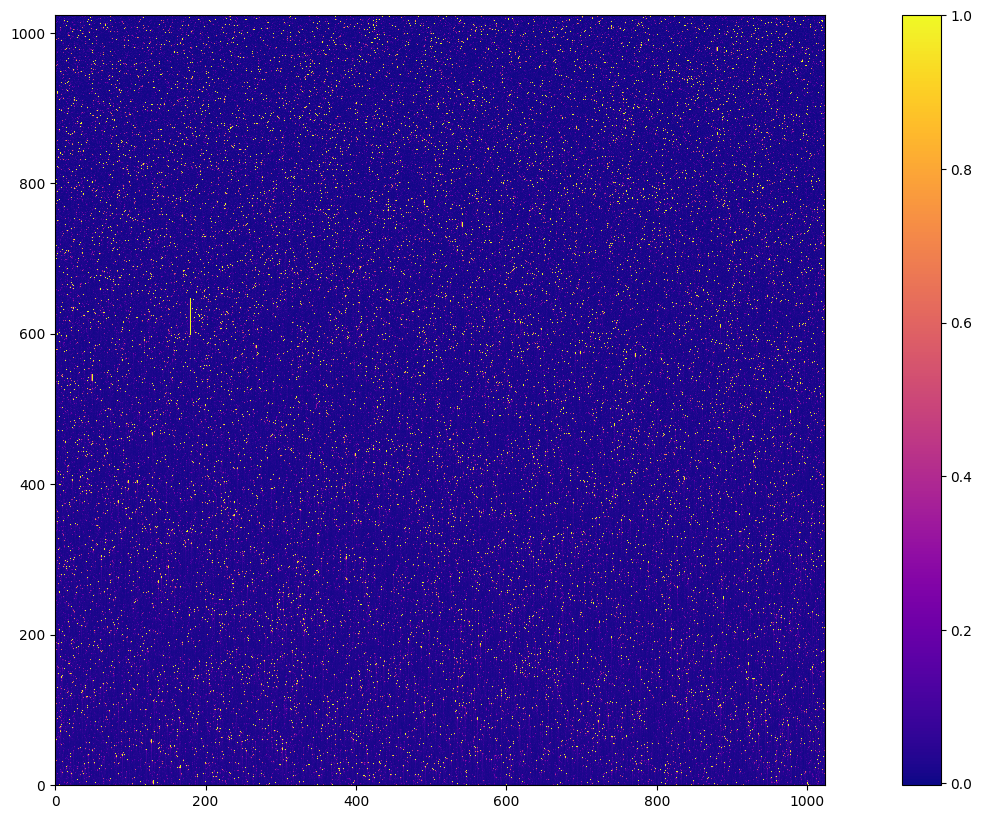

In [9]:
with fits.open(new_basedark) as hdu:
    new_basedark_data = hdu[1].data
cb = plt.imshow(new_basedark_data, cmap='plasma', vmax=1)
plt.colorbar(cb)

## Make Weekdark
The Weekdark is the combination of all "long" dark files from the week of the science observation, which is eventually passed into the Calstis pipline as the DARKFILE for the DARKCORR calibration. After the darks during a given week is combined and normalized to produce a weekly superdark, those hotpixels in the monthly Basedark are replaced by those of the normalized weekly superdark. The resulting dark has the high signal-to-noise ratio of the monthly baseline superdark, updated with the hot pixels of the current week.

We first search for the darks taken during the given week. We take the weekly period as the observation date ± 3 days in this demonstration, 
**but notice here that since the observation time is 2021-05-05 12:29:54 while the ending time of the annealing period is 2021-05-05 14:00:22, observation date + 3 days will cross the annealing boundary.** Therefore, in our case, we only take the observation date - 3 days as the weekly period. When you work with your own dataset, pay attention to the week boundary and annealing boundary to see if they completely overlap.

In [10]:
# search for darks taken during the weekly period (observation date, observation date + 3 days)
hdr = fits.getheader(crj, 0)
component_darks = Observations.query_criteria(
    target_name='DARK',
    t_min=[hdr['TEXPSTRT']-3, hdr['TEXPSTRT']],
    t_exptime=[1099, 1101])
# get a list of files assiciated with that target
dark_list = Observations.get_product_list(component_darks)
dark_list = dark_list[dark_list['productSubGroupDescription'] == 'FLT']
# store all the paths to the superdark frames into a list
component_flt = [filename_mapping[x] for x in component_darks['obs_id']]
component_flt

[np.str_('./mastDownload/HST/oeen9za2q/oeen9za2q_flt.fits'),
 np.str_('./mastDownload/HST/oeena0aaq/oeena0aaq_flt.fits'),
 np.str_('./mastDownload/HST/oeena1g5q/oeena1g5q_flt.fits'),
 np.str_('./mastDownload/HST/oeena2gcq/oeena2gcq_flt.fits'),
 np.str_('./mastDownload/HST/oeena3kjq/oeena3kjq_flt.fits'),
 np.str_('./mastDownload/HST/oeena4knq/oeena4knq_flt.fits')]

Now we have all the dark files we need to create the new weekdark reference file. Pass the list of the weekly component darks as the first parameter, the name of the new weekdark file as the second parameter, and the new basedark file we created above as the third parameter into refstis.make_weekdark. For more information on make_weekdark, see: [Weekdark](https://refstis.readthedocs.io/en/latest/api/weekdark.html).

In [11]:
new_weekdark = "new_weekdark.fits"
# remove the new_basedark file if it already exists
if os.path.exists(new_weekdark):
    os.remove(new_weekdark)
make_weekdark(component_flt, new_weekdark, thebasedark=new_basedark)

#-------------------------------#
#        Running weekdark       #
#-------------------------------#
Making weekdark new_weekdark.fits
With : oref$55a2044do_bia.fits
     : new_basedark.fits
BIAS correction already done for ./mastDownload/HST/oeen9za2q/oeen9za2q_flt.fits
BIAS correction already done for ./mastDownload/HST/oeena0aaq/oeena0aaq_flt.fits
BIAS correction already done for ./mastDownload/HST/oeena1g5q/oeena1g5q_flt.fits
BIAS correction already done for ./mastDownload/HST/oeena2gcq/oeena2gcq_flt.fits
BIAS correction already done for ./mastDownload/HST/oeena3kjq/oeena3kjq_flt.fits
BIAS correction already done for ./mastDownload/HST/oeena4knq/oeena4knq_flt.fits
TEMPCORR = COMPLETE, no temperature correction applied to ./mastDownload/HST/oeen9za2q/oeen9za2q_flt.fits
TEMPCORR = COMPLETE, no temperature correction applied to ./mastDownload/HST/oeena0aaq/oeena0aaq_flt.fits
TEMPCORR = COMPLETE, no temperature correction applied to ./mastDownload/HST/oeena1g5q/oeena1g5q_flt.fits
TEMP

>>>> Updated keyword NRPTEXP to 6.0
    (and set keyword CRSPLIT to 1)
     in new_weekdark_joined.fits
## crdone is  0
Running CalSTIS on new_weekdark_joined.fits
to create: new_weekdark_joined_crj.fits


Normalizing by  6600.0


hot pixels are defined as above:  0.104120255


Cleaning up...
Weekdark done for new_weekdark.fits


## Calibrate with New Weekdark
### Calibration
Now we have created the new weekdark reference file for our specific dataset, we can use it to calibrate the raw data using Calstis. To change the dark reference file, we first set the value of DARKFILE in the _raw data 0th header using fits.setval. Calstis will then look for the DARKFILE value and use it as the reference file for DARKCORR.

In [12]:
raw = os.path.join("./mastDownload/HST", "{}".format(obs_id), "{}_raw.fits".format(obs_id))
wav = os.path.join("./mastDownload/HST", "{}".format(obs_id), "{}_wav.fits".format(obs_id))

In [13]:
# set the value of DARKFILE to the filename of the new week dark
fits.setval(raw, ext=0, keyword='DARKFILE', value=new_weekdark)
# make sure that the value is set correctly
fits.getval(raw, ext=0, keyword='DARKFILE')

'new_weekdark.fits'

Calibrate the _raw data using the new weekdark reference file:

In [14]:
# create a new folder to store the calibrated data
if os.path.exists('./new_dark'):
    shutil.rmtree('./new_dark')
Path('./new_dark').mkdir(exist_ok=True)
res = stistools.calstis.calstis(raw, wavecal=wav, outroot="./new_dark/")
assert res == 0, 'CalSTIS returned an error!'


*** CALSTIS-0 -- Version 3.4.2 (19-Jan-2018) ***
Begin    04-Dec-2024 19:02:01 UTC

Input    ./mastDownload/HST/oeik1s030/oeik1s030_raw.fits
Outroot  ./new_dark/oeik1s030_raw.fits
Wavecal  ./mastDownload/HST/oeik1s030/oeik1s030_wav.fits
Warning  DARKFILE is not the same in the science and wavecal headers; \
Warning  values in the science and wavecal are respectively: \
Warning  `new_weekdark.fits' \
Warning  `oref$55a20445o_drk.fits' \
Warning  The value from the science header will be used for the wavecal.

*** CALSTIS-1 -- Version 3.4.2 (19-Jan-2018) ***
Begin    04-Dec-2024 19:02:01 UTC
Input    ./mastDownload/HST/oeik1s030/oeik1s030_raw.fits
Output   ./new_dark/oeik1s030_blv_tmp.fits
OBSMODE  ACCUM
APERTURE 52X2
OPT_ELEM G750L
DETECTOR CCD

Imset 1  Begin 19:02:01 UTC
Epcfile  oeik1snkj_epc.fits
Warning  EPCTAB `oeik1snkj_epc.fits' not found.

CCDTAB   oref$16j1600do_ccd.fits
CCDTAB   PEDIGREE=GROUND
CCDTAB   DESCRIP =Updated amp=D gain=4 atodgain and corresponding readnoise value

DQICORR  COMPLETE

ATODCORR OMIT

BLEVCORR PERFORM
         Bias level from overscan has been subtracted; \
         mean of bias levels subtracted was 1541.41.
BLEVCORR COMPLETE
         Uncertainty array initialized, readnoise=8.2328, gain=4.016

BIASCORR PERFORM
BIASCORR COMPLETE

DARKCORR OMIT

FLATCORR OMIT

SHADCORR OMIT
Imset 4  End 19:02:01 UTC

End      04-Dec-2024 19:02:01 UTC

*** CALSTIS-1 complete ***

*** CALSTIS-2 -- Version 3.4.2 (19-Jan-2018) ***
Begin    04-Dec-2024 19:02:01 UTC
Input    ./new_dark/oeik1s030_blv_tmp.fits
Output   ./new_dark/oeik1s030_crj_tmp.fits

CRCORR   PERFORM
Total number of input image sets = 4
CRREJTAB oref$j3m1403io_crr.fits


CRCORR   COMPLETE

End      04-Dec-2024 19:02:01 UTC

*** CALSTIS-2 complete ***

*** CALSTIS-1 -- Version 3.4.2 (19-Jan-2018) ***
Begin    04-Dec-2024 19:02:01 UTC
Input    ./new_dark/oeik1s030_crj_tmp.fits
Output   ./new_dark/oeik1s030_crj.fits
OBSMODE  ACCUM
APERTURE 52X2
OPT_ELEM G750L
DETECTOR CCD

Imset 1  Begin 19:02:01 UTC

CCDTAB   oref$16j1600do_ccd.fits
CCDTAB   PEDIGREE=GROUND
CCDTAB   DESCRIP =Updated amp=D gain=4 atodgain and corresponding readnoise values---
CCDTAB   DESCRIP =Oct. 1996 Air Calibration

DQICORR  OMIT

ATODCORR OMIT

BLEVCORR OMIT

BIASCORR OMIT

DARKCORR PERFORM
DARKFILE new_weekdark.fits
DARKFILE PEDIGREE=INFLIGHT 03/05/2021 05/05/2021
DARKFILE DESCRIP =Weekly gain=1 dark for STIS CCD data taken after May 03 2021-------
DARKCORR COMPLETE

FLATCORR PERFORM
PFLTFILE oref$x6417096o_pfl.fits
PFLTFILE PEDIGREE=INFLIGHT 24/10/2011 24/06/2012
PFLTFILE DESCRIP =REVISED ON-ORBIT STIS SPECTROSCOPIC CCD P-FLAT FOR L-MODES---------
LFLTFILE oref$pcc2026ko_lfl.fits
L

Imset 1  End 19:02:01 UTC

End      04-Dec-2024 19:02:01 UTC

*** CALSTIS-1 complete ***

*** CALSTIS-1 -- Version 3.4.2 (19-Jan-2018) ***
Begin    04-Dec-2024 19:02:01 UTC
Input    ./new_dark/oeik1s030_blv_tmp.fits
Output   ./new_dark/oeik1s030_flt.fits
OBSMODE  ACCUM
APERTURE 52X2
OPT_ELEM G750L
DETECTOR CCD

Imset 1  Begin 19:02:01 UTC
Epcfile  oeik1snkj_epc.fits
Warning  EPCTAB `oeik1snkj_epc.fits' not found.

CCDTAB   oref$16j1600do_ccd.fits
CCDTAB   PEDIGREE=GROUND
CCDTAB   DESCRIP =Updated amp=D gain=4 atodgain and corresponding readnoise values---
CCDTAB   DESCRIP =Oct. 1996 Air Calibration

DQICORR  OMIT

ATODCORR OMIT

BLEVCORR OMIT

BIASCORR OMIT

DARKCORR PERFORM
DARKFILE new_weekdark.fits
DARKFILE PEDIGREE=INFLIGHT 03/05/2021 05/05/2021
DARKFILE DESCRIP =Weekly gain=1 dark for STIS CCD data taken after May 03 2021-------
DARKCORR COMPLETE

FLATCORR PERFORM
PFLTFILE oref$x6417096o_pfl.fits
PFLTFILE PEDIGREE=INFLIGHT 24/10/2011 24/06/2012
PFLTFILE DESCRIP =REVISED ON-ORBIT S

Epcfile  oeik1snlj_epc.fits
Warning  EPCTAB `oeik1snlj_epc.fits' not found.

DQICORR  OMIT

ATODCORR OMIT

BLEVCORR OMIT

BIASCORR OMIT

DARKCORR PERFORM
DARKCORR COMPLETE

FLATCORR PERFORM
FLATCORR COMPLETE

SHADCORR OMIT

STATFLAG PERFORM
STATFLAG COMPLETE
Imset 2  End 19:02:02 UTC

Imset 3  Begin 19:02:02 UTC
Epcfile  oeik1snmj_epc.fits


Warning  EPCTAB `oeik1snmj_epc.fits' not found.

DQICORR  OMIT

ATODCORR OMIT

BLEVCORR OMIT

BIASCORR OMIT

DARKCORR PERFORM
DARKCORR COMPLETE

FLATCORR PERFORM
FLATCORR COMPLETE

SHADCORR OMIT

STATFLAG PERFORM
STATFLAG COMPLETE
Imset 3  End 19:02:02 UTC

Imset 4  Begin 19:02:02 UTC
Epcfile  oeik1snnj_epc.fits
Warning  EPCTAB `oeik1snnj_epc.fits' not found.

DQICORR  OMIT

ATODCORR OMIT

BLEVCORR OMIT

BIASCORR OMIT

DARKCORR PERFORM


DARKCORR COMPLETE

FLATCORR PERFORM
FLATCORR COMPLETE

SHADCORR OMIT

STATFLAG PERFORM
STATFLAG COMPLETE
Imset 4  End 19:02:02 UTC

End      04-Dec-2024 19:02:02 UTC

*** CALSTIS-1 complete ***

*** CALSTIS-1 -- Version 3.4.2 (19-Jan-2018) ***
Begin    04-Dec-2024 19:02:02 UTC
Input    ./mastDownload/HST/oeik1s030/oeik1s030_wav.fits
Output   ./new_dark/oeik1s030_fwv_tmp.fits
OBSMODE  ACCUM
APERTURE 52X0.1
OPT_ELEM G750L
DETECTOR CCD

Imset 1  Begin 19:02:02 UTC
Epcfile  oeik1snoj_epc.fits
Warning  EPCTAB `oeik1snoj_epc.fits' not found.

CCDTAB   oref$16j1600do_ccd.fits
CCDTAB   PEDIGREE=GROUND
CCDTAB   DESCRIP =Updated amp=D gain=4 atodgain and corresponding readnoise values---
CCDTAB   DESCRIP =Oct. 1996 Air Calibration

DQICORR  PERFORM
DQITAB   oref$h1v11475o_bpx.fits
DQITAB   PEDIGREE=GROUND
DQITAB   DESCRIP =Prel. Ground Calib
DQICORR  COMPLETE

ATODCORR OMIT

BLEVCORR PERFORM
         Bias level from overscan has been subtracted; \
         mean of bias levels subtracted was 1540

DARKCORR COMPLETE

FLATCORR PERFORM
PFLTFILE oref$x6417096o_pfl.fits
PFLTFILE PEDIGREE=INFLIGHT 24/10/2011 24/06/2012
PFLTFILE DESCRIP =REVISED ON-ORBIT STIS SPECTROSCOPIC CCD P-FLAT FOR L-MODES---------
LFLTFILE oref$pcc2026ko_lfl.fits
LFLTFILE PEDIGREE=INFLIGHT 27/05/1997 27/05/1997
LFLTFILE DESCRIP =CCD G750L Low-Order Flat
FLATCORR COMPLETE

SHADCORR OMIT

PHOTCORR OMIT

STATFLAG PERFORM
STATFLAG COMPLETE
Imset 1  End 19:02:02 UTC

End      04-Dec-2024 19:02:02 UTC

*** CALSTIS-1 complete ***

*** CALSTIS-7 -- Version 3.4.2 (19-Jan-2018) ***
Begin    04-Dec-2024 19:02:02 UTC
Input    ./new_dark/oeik1s030_fwv_tmp.fits
Output   ./new_dark/oeik1s030_w2d_tmp.fits
OBSMODE  ACCUM
APERTURE 52X0.1
OPT_ELEM G750L
DETECTOR CCD
Imset 1  Begin 19:02:02 UTC

Order 1  Begin 19:02:02 UTC

X2DCORR  PERFORM
DISPCORR PERFORM
APDESTAB oref$16j16005o_apd.fits
APDESTAB PEDIGREE=INFLIGHT 01/03/1997 13/06/2017
APDESTAB DESCRIP =Aligned long-slit bar positions for single-bar cases.--------------
APDESTAB 

FLAGCR   COMPLETE
         Shift in dispersion direction is 2.957 pixels.
         Shift in spatial direction is -1.950 pixels.
WAVECORR COMPLETE
Imset 1  End 19:02:03 UTC

End      04-Dec-2024 19:02:03 UTC

*** CALSTIS-4 complete ***

*** CALSTIS-12 -- Version 3.4.2 (19-Jan-2018) ***
Begin    04-Dec-2024 19:02:03 UTC
Wavecal  ./new_dark/oeik1s030_w2d_tmp.fits
Science  ./new_dark/oeik1s030_crj.fits
OBSMODE  ACCUM
APERTURE 52X2
OPT_ELEM G750L
DETECTOR CCD
Imset 1  Begin 19:02:03 UTC
         SHIFTA1 set to 2.95707
         SHIFTA2 set to -1.94995
Imset 1  End 19:02:03 UTC

End      04-Dec-2024 19:02:03 UTC

*** CALSTIS-12 complete ***

*** CALSTIS-12 -- Version 3.4.2 (19-Jan-2018) ***
Begin    04-Dec-2024 19:02:03 UTC
Wavecal  ./new_dark/oeik1s030_w2d_tmp.fits
Science  ./new_dark/oeik1s030_flt.fits
OBSMODE  ACCUM
APERTURE 52X2
OPT_ELEM G750L
DETECTOR CCD
Imset 1  Begin 19:02:03 UTC
         SHIFTA1 set to 2.95707
         SHIFTA2 set to -1.94995
Imset 1  End 19:02:03 UTC
Imset 2  Begin 

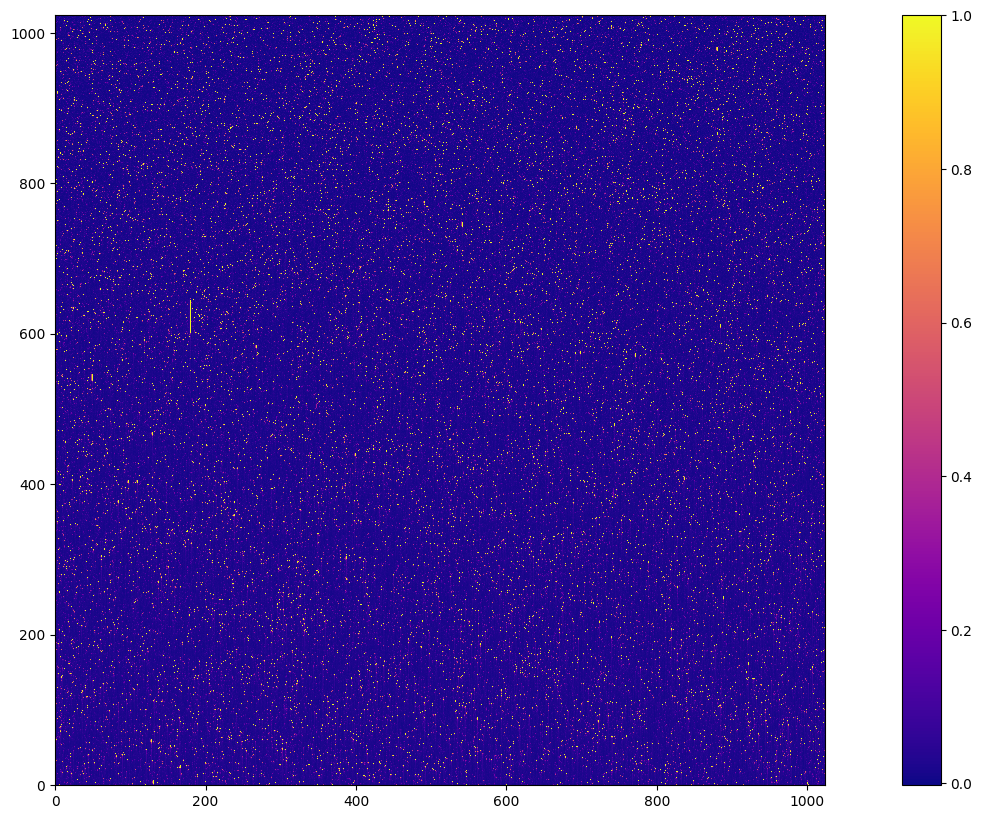

In [15]:
with fits.open('new_weekdark.fits') as hdu:
    new_weekdark_data = hdu[1].data
cb = plt.imshow(new_weekdark_data, cmap='plasma', vmax=1)
plt.colorbar(cb)

To compare the new weekdark science image with the old weekdark science image, we divide the new weekdark science image frame by that of the old weekdark, and use a diverging colormap to visulize the ratio. The colormap is normalized to center at 1, and the red pixels suggests that the ratio is greater than 1 while the blue pixels suggests that the ratio is less than 1. In general there are more blue pixels in the image, which means we are removing more hot pixels compared with the old weekdark.

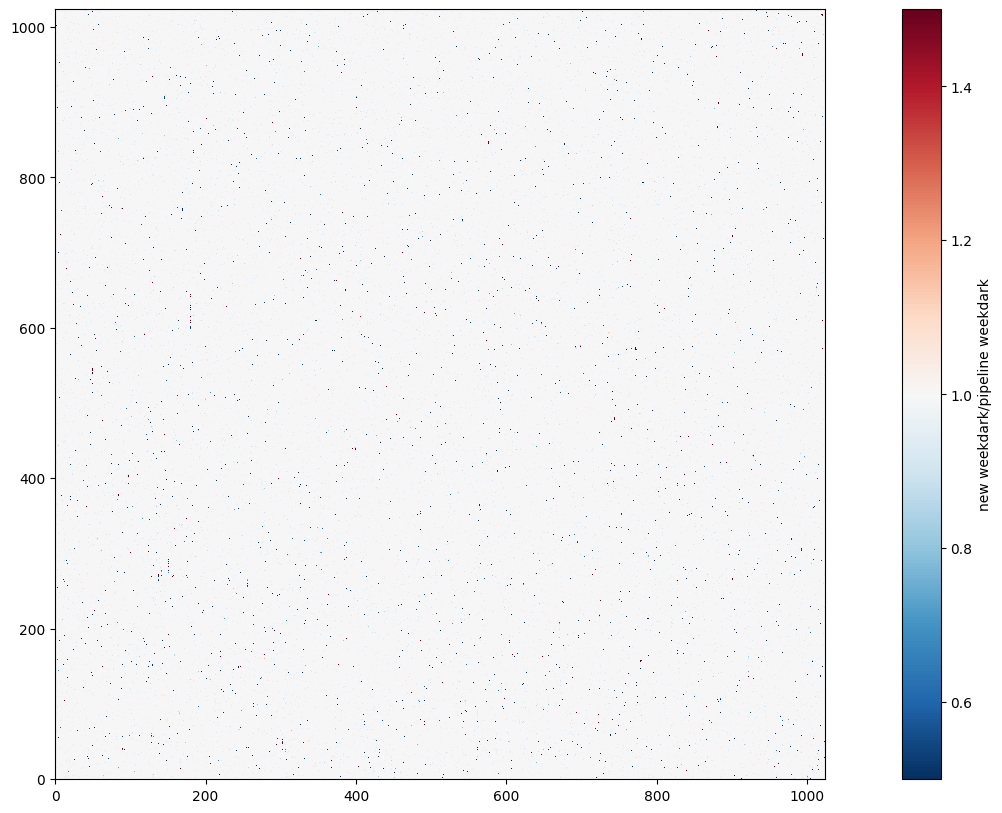

In [16]:
with fits.open("55a20445o_drk.fits") as hdu:
    old_weekdark_data = hdu[1].data
cb = plt.imshow(new_weekdark_data/old_weekdark_data, cmap='RdBu_r', vmin=0.5, vmax=1.5)
plt.colorbar(cb, label="new weekdark/pipeline weekdark")

### Comparison With the Default Dark File
When we collected the science data from MAST, the _crj and _sx1 data files are already calibrated using the default dark reference file. We can make a comparison between the calibrated images and spectra of the defualt dark file and our new Weekdark. As shown in the comparison, a hot pixel is removed from the _crj image at x $\approx$ 605 and y $\approx$ 185.

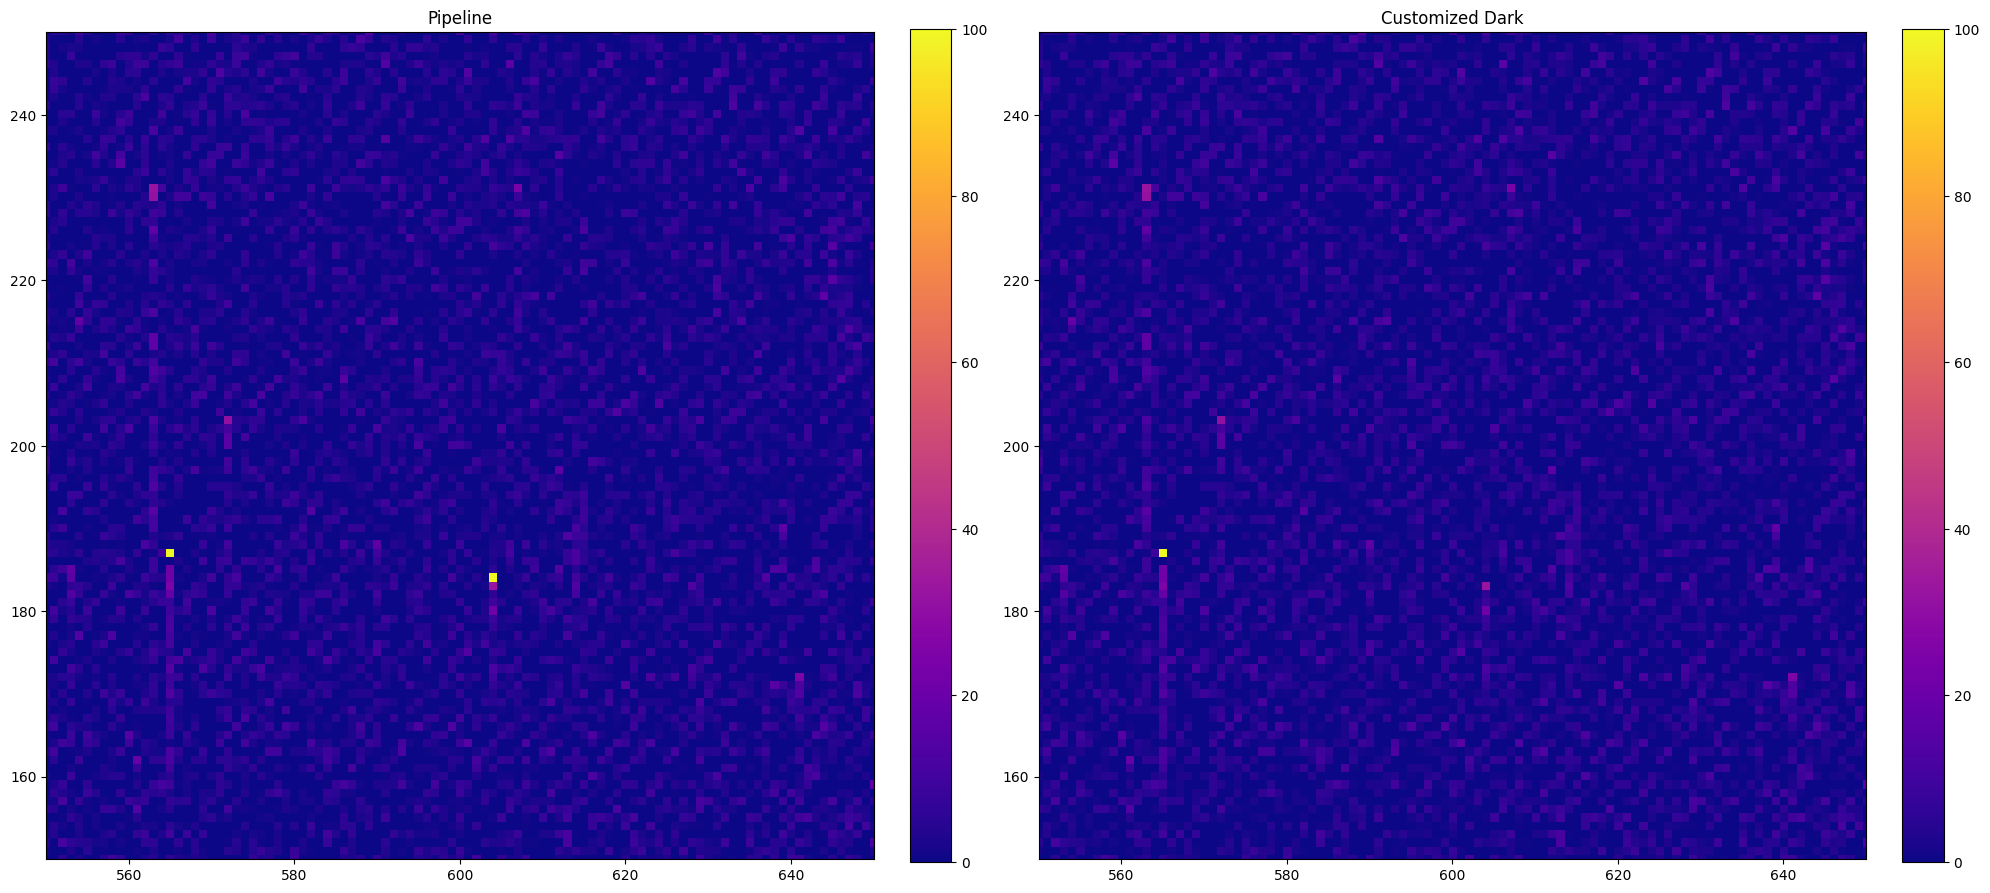

In [17]:
# Plot the calibrated _crj images
# The left panel is the defalt _crj image from the pipline
# the right panel is calibrated with our customized dark file
plt.subplot(1, 2, 1)
with fits.open(crj) as hdu:
    ex1 = hdu[1].data
    cb = plt.imshow(ex1, vmin=0, vmax=100)
    plt.colorbar(cb, fraction=0.046, pad=0.04)
    plt.xlim(550, 650)
    plt.ylim(150, 250)
    plt.title("Pipeline")
plt.subplot(1, 2, 2)
with fits.open("./new_dark/oeik1s030_crj.fits") as hdu:
    ex1 = hdu[1].data
    cb = plt.imshow(ex1, vmin=0, vmax=100)
    plt.colorbar(cb, fraction=0.046, pad=0.04)
    plt.xlim(550, 650)
    plt.ylim(150, 250)
    plt.title("Customized Dark")
plt.tight_layout()

We can also visualize the flux difference in the _sx1 spectra in which we substrct the recalibrated spectrum by the pipeline spectrum:

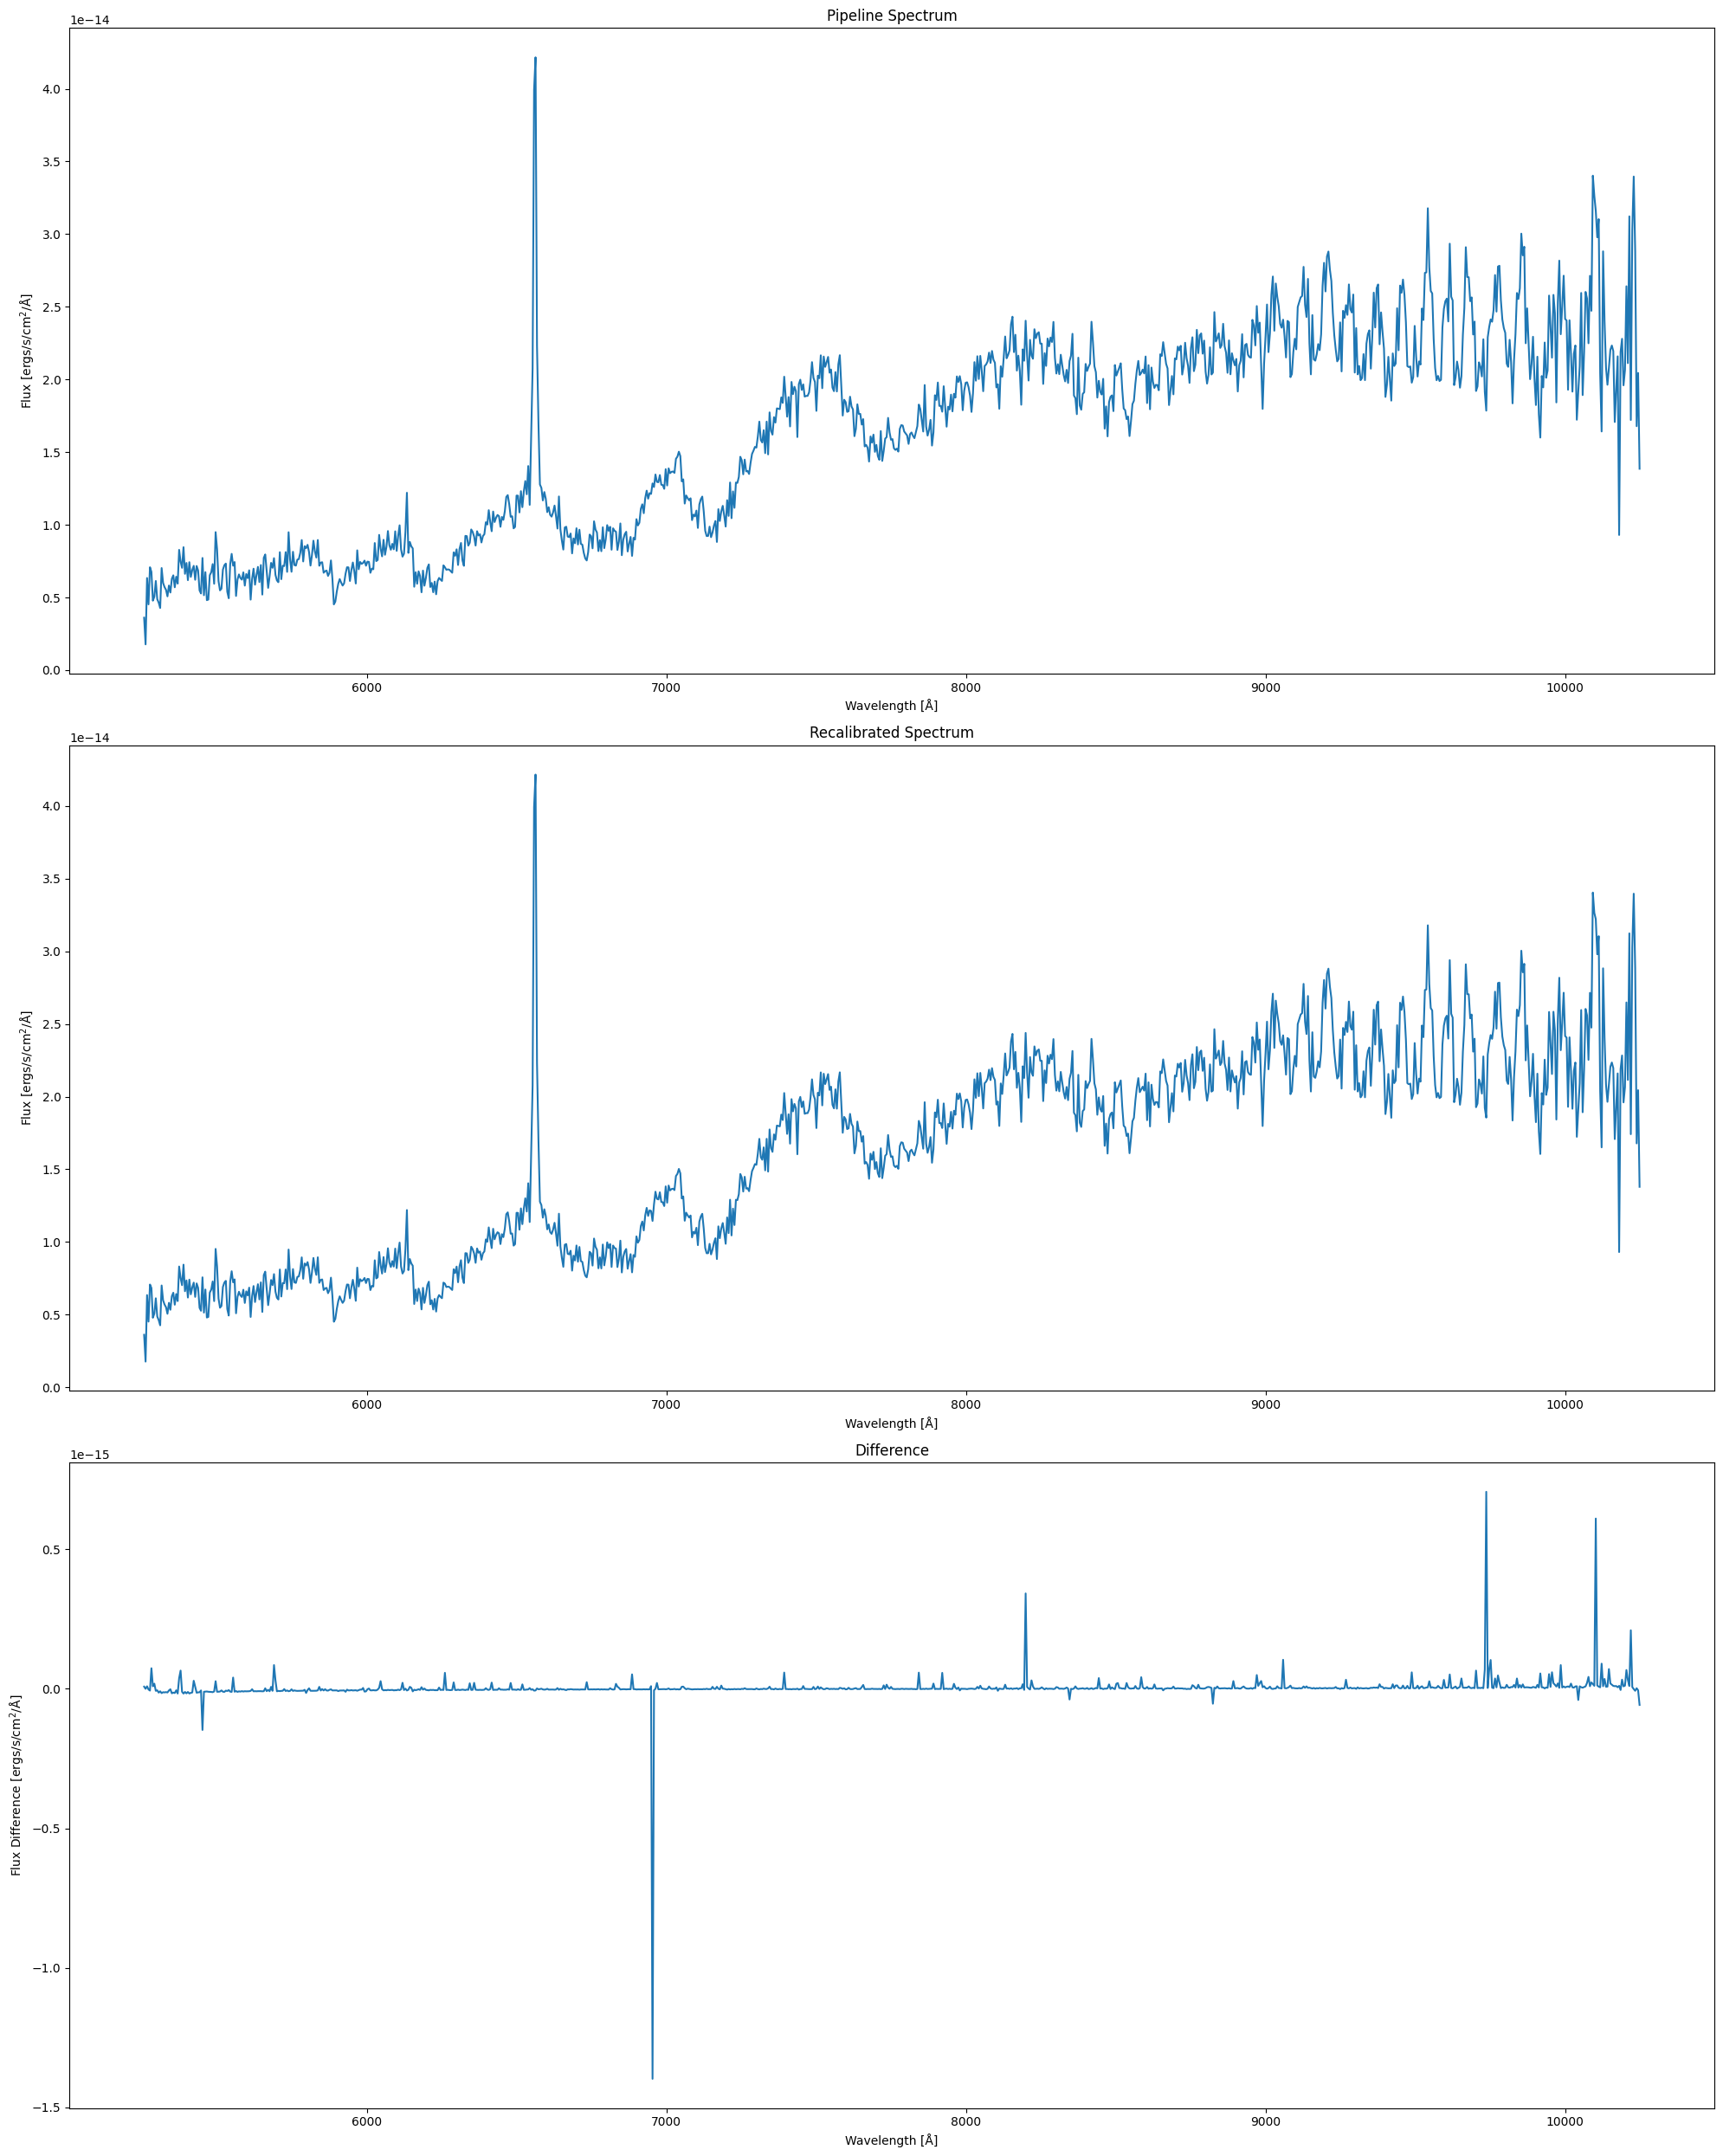

In [18]:
plt.figure(figsize=(20, 25))
# get the spectrum of the default pipline _sx1 data
pip = Table.read("./mastDownload/HST/oeik1s030/oeik1s030_sx1.fits", 1)
wl, pip_flux = pip[0]["WAVELENGTH", "FLUX"]
# get the flux of the customized new_dark _sx1 data
cus = Table.read("./new_dark/oeik1s030_sx1.fits", 1)
cus_wl, cus_flux = cus[0]["WAVELENGTH", "FLUX"]
# interpolant flux so that the wavelengths matches
interp_flux = np.interp(wl, cus_wl, cus_flux)
# plot the pipeline spectrum
plt.subplot(3, 1, 1)
plt.plot(wl, pip_flux)
plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux [ergs/s/cm$^2$/Å]")
plt.title("Pipeline Spectrum")
# plot the pipeline spectrum
plt.subplot(3, 1, 2)
plt.plot(cus_wl, cus_flux)
plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux [ergs/s/cm$^2$/Å]")
plt.title("Recalibrated Spectrum")
# plot the spectra difference
plt.subplot(3, 1, 3)
plt.plot(wl, interp_flux-pip_flux)
plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux Difference [ergs/s/cm$^2$/Å]")
plt.title("Difference")
plt.tight_layout()


---
## About this Notebook <a class="tocSkip">
**Author:** [Keyi Ding](kding@stsci.edu)

**Updated On:** 2023-04-14


> *This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*
## Citations <a class="tocSkip">

If you use `astropy`, `matplotlib`, `astroquery`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citations:

* [Citing `astropy`/`numpy`/`matplotlib`](https://www.scipy.org/citing.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)

---

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 